# Introduction
This notebook is aimed to host data from the Titanic dataset for Kaggle's competition. We aimed to analyze and predict which passengers from the Titanic will survive.

### Imports
Import libraries establish settings.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from collections import Counter

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Data analysis
import pingouin as pg
import scipy.stats as stats
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats as smstats
from sklearn.feature_selection import f_classif, SelectKBest, chi2, mutual_info_classif, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import PowerTransformer
# set matplotlib parameters

# warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\sebas\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\sebas\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.5, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\sebas\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Exploratory Data Analysis (EDA)

## Import data

Train and test data we give already splitted, so we are not going to implement sklearn tran-test split, we are just going to load the dataset that were given in csv files.

We can see that in the test dataset we have all the features except the target variable "Survived"

In [2]:
# path to the file
path_train = "train.csv"
path_test = "test.csv"

# import csv
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)
display(train.head())
display(test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Now, let's drop the target variable from the train data in order to create a DataFrame with just the predictors "X_train", or features, that the model should used to be trained. Also, we are going to store the target variable into "y_train". Let's print their shapes to check that we do not have a mismatch in the number of rows.

In [3]:
X_train = train.drop(columns="Survived")
y_train = train["Survived"]
display(X_train.head(), y_train.head())
print("Shapes of both, X and y train sets:", X_train.shape, y_train.shape)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

Shapes of both, X and y train sets: (891, 11) (891,)


## Missing values

Let's explore what kind of data the Dataset holds.

We have numerical and categorical data. Most of the columns contains non-null values, although we can see that missing values are found in Age (177), Cabin (687) and some in Embarked (2) columns.

For this, we would try to adopt some strategies. 

* First, we will first explore if there are differences between Passenger Class in Age. In case there are statistically significant differences, we will impute the NaN values in Age  with the mean of its corresponding class group.


* Second, it could be possible that NaN values for Cabin could correspond to those in third class that do not have a cabin assigned. In any case, we will first see if for null-values in Cabin we only have "3" as unique value.


* Third, we will try to find some information in the Dataset to impute missing values in Embarked. If we do not find any convincing information, we will try to search on the internet to have a better understanding of the data.

In [174]:
# DataFrame information
train.info()

# missing values in Age, Cabin and Embarked
pd.DataFrame(data=train[["Age", "Cabin", "Embarked"]].isnull().sum(), columns=["Missing values"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,Missing values
Age,177
Cabin,687
Embarked,2


### Missing values in Age

First, let's explore descriptive statistics for numerical data. We can see that we have a minimum Age of 0.42, which should correspond to the age of an infant. The maximum value is 80, so everything normal until here. The standard deviations also seems reasonable as the mean and median.


Also, we see that Pclass is between 1 and 3, so no unexpected values in that column. 


Interestingly, we have a minimum Fare value of zero, so that means that there are some people that did not pay for his/her ticket. We standard deviation is quite high, but this is because we have a huge range of values if we take a look to the minimum and maximum values. We would expect there values to be quite spread.

In [175]:
# descriptive statistics for numeric variables
display(train[["Age", "Fare", "Pclass"]].describe())

# unique values in Pclass
print("We have these unique values in Pclass column:", sorted(list(train["Pclass"].unique())))

,Age,Fare,Pclass
count,714.000000,891.000000,891.000000
mean,29.699118,32.204208,2.308642
std,14.526497,49.693429,0.836071
min,0.420000,0.000000,1.000000
25%,20.125000,7.910400,2.000000
50%,28.000000,14.454200,3.000000
75%,38.000000,31.000000,3.000000
max,80.000000,512.329200,3.000000


We have these unique values in Pclass column: [1, 2, 3]


Now, we will test if there are statistically significant differences in Age based on Passenger Class and Sex. We will use Analysis of Variance (ANOVA). 

From the ANOVA, we see that there is a statistically significant difference, so we should replace NaN values for each Passenger Class with the mean of its corresponding class. The main effect of Sex is also statistically significant, but not Passenger Class and Sex. From the boxplots, we can see that there seems to be a difference in Age by Sex in First and Third class, so in order to try to catch this differences in Age by Passenger Class and Sex, we are going to impute Age based on both, although the non-statistically significant interaction indicates and absence of differences in Age.

In [176]:
# descriptive statistics by Pclass
display(train.groupby(["Pclass"])["Age"].describe().T.rename(columns={1: 'First class', 2: 'Second class', 3: 'Third class'}))

# ANOVA
print("ANOVA to test for differences between Pclass and Sex")
display(pg.anova(data=train[["Pclass", "Sex", "Age"]], dv="Age", between=["Pclass", "Sex"], detailed=False).round(3))

Pclass,First class,Second class,Third class
count,186.000000,173.000000,355.000000
mean,38.233441,29.877630,25.140620
std,14.802856,14.001077,12.495398
min,0.920000,0.670000,0.420000
25%,27.000000,23.000000,18.000000
50%,37.000000,29.000000,24.000000
75%,49.000000,36.000000,32.000000
max,80.000000,70.000000,74.000000


ANOVA to test for differences between Pclass and Sex


,Source,SS,DF,MS,F,p-unc,np2
0,Pclass,23010.355,2.0,11505.178,64.825,0.000,0.155
1,Sex,3389.133,1.0,3389.133,19.096,0.000,0.026
2,Pclass * Sex,481.844,2.0,240.922,1.357,0.258,0.004
3,Residual,125656.031,708.0,177.480,NaN,NaN,NaN


From Age's distribution we can see that older ages are more common along the first class. This makes sense, as in the first class we should have found people from a high socioeconomic background, hence they were able to afford a better lifestyle and better health care. On the other hand, we can see that the upper boundary of the interquartile range is around 55 years of age, and a few outliers above that.

Comparing ages between sexes, we can se that no large differences are found, although we can see some outliers for males ages.

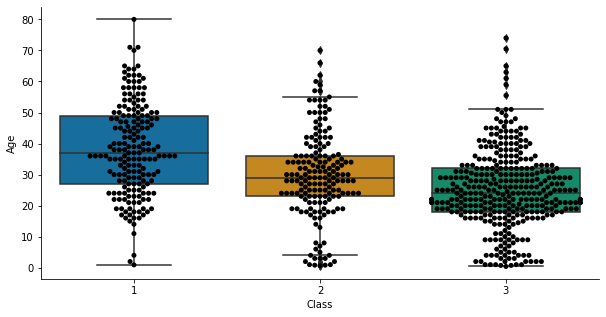

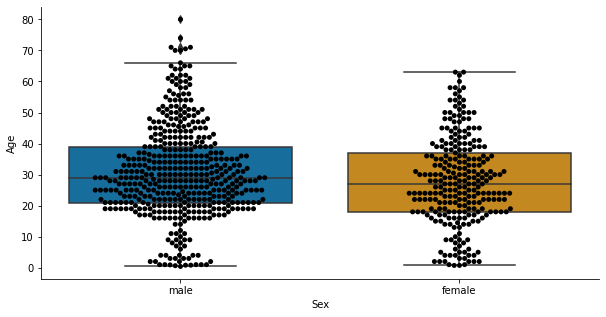

In [177]:
fig, ax0 = plt.subplots(figsize=(10, 5))
sns.boxplot(x=train["Pclass"], y=train["Age"], palette="colorblind")
sns.swarmplot(x=train["Pclass"], y=train["Age"], color="black")
ax0.set_xlabel("Class")
sns.despine()

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.boxplot(x=train["Sex"], y=train["Age"], palette="colorblind")
sns.swarmplot(x=train["Sex"], y=train["Age"], color="black")
ax1.set_xlabel("Sex")
sns.despine()

### Exploring Fare

As we said before, we have quite spread values in Fare but just because there are some outliers above the 1.5 times the interquartile range (IQR). Exploring the boxplot se can see that most of the values are inside the IQR and, and some between the upper and lower value of 1.5 times the IQR. We can consider removing these values, but it could also be variability in the data, and also be related to survival (higher classes could have been prioretized). Let's see how the thing looks for each class. 

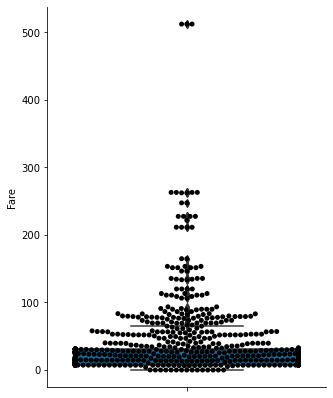

In [178]:
fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(y=train["Fare"], palette="colorblind")
sns.swarmplot(y=train["Fare"], color="black")
sns.despine()

As expected, most of the biggest outliers belong to first class. Although, we can also see some outliers for second and third class. There are also some third class passengers that paid the same Fare that First and Second class passengers. How can be this possible? It seems weird that Third class were paying the same Fares to be in the lowest class.

As an option, we can create a Custom Transformer that computes the lower and upper boundary of the 1.5 times the IQR, and replace the outlier values for the maximum value of the distribution for each class or the mean. We can include it in a Pipeline, and compare how the model works with and without outliers.

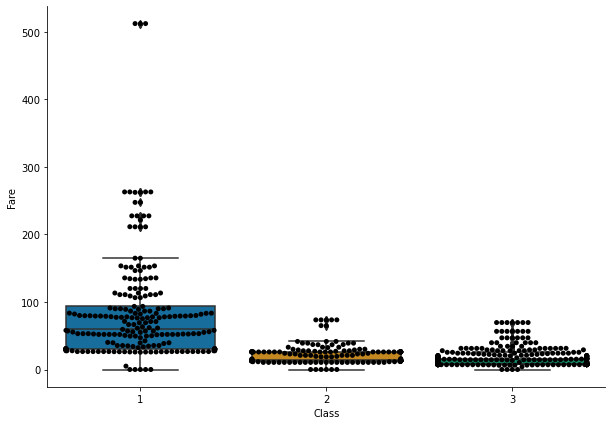

In [43]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(x=train["Pclass"], y=train["Fare"], palette="colorblind")
sns.swarmplot(x=train["Pclass"], y=train["Fare"], color="black")
ax.set_xlabel("Class")
sns.despine()

### Missing values in Cabin

Exploring the data, we have discovered that we cannot make an automatic replacement for Cabin, as we have NaN values not only for third class, but for first and second too. Once discovered this, we will replace NaN values for in Cabin with "Unspecified" independently of the Class, this could also be informative. 

Searching on the internet, third class cabins were located at the lower levels of the ship, while second and first class were located in the upper floors. It seems that Cabins in the Titanic were not evenly distributed by floors, as different class Cabins could be located on the same floor. We can also see that there is a T boat deck, and some 1st class cabins were located at E deck.

In [44]:
# unique values of Pclass for missing values in Cabin
print("We have missing values for Cabin in the following Passenger Class", train[train["Cabin"].isnull()]["Pclass"].unique())
train["Cabin"] = np.where(train["Cabin"].isnull(), "Unspecified", train["Cabin"])
display(train.head())

We have missing values for Cabin in the following Passenger Class [3 2 1]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unspecified,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unspecified,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unspecified,S


### Missing values in Embarked

We couldn't gather any additional information based on Ticket or Cabin to replace missing values in Embarked. However, looking for information on the internet we found that Miss Amelie Icard traveled in the Titanic as maid to Mrs. Martha Evelyn, and they embarked in Southampton, so we will replace these missing values with an "S" for Southampton.

In [45]:
# rows for missing values in Embarked
display(train[train["Embarked"].isnull()])

# replace Embarked missing values
train.loc[(train["Cabin"] == "B28"), "Embarked"] = "S"
train[train["Cabin"] == "B28"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


## Feature engineering

### New ticket features based on Ticket information

The Ticket feature contains a lot of interesting information. We will try to extract more useful features splitting the ticket data into two, one variable including the first letters of the ticket as it seems to code something more specific. The other will contain the rest of the ticket information, mainly as numerical data.

In [46]:
# empty DataFrame to contain the splitted information
empty = pd.DataFrame()

# split the data based on white spaces
empty = train["Ticket"].str.split(pat=' ', n=1, expand=True)

# rename the columns
empty.rename({0: "Ticket_L", 1: "Ticket_N"}, axis=1, inplace=True)

# merge into the train DataFrame the splitted data
train = train.merge(empty, left_on=train.index, right_on=empty.index).drop(columns='key_0')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unspecified,S,A/5,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unspecified,S,STON/O2.,3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,None
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unspecified,S,373450,None


### New Deck and Section features based on Cabin


Looking for information on the internet, we have found that the letter of the Cabin designated the range of floors that covered. So in order to simplify this feature, we will also store the deck letter in a separate column. Exploring values in third class we have discovered that there are also some passengers that have a double letter on their Cabin, like Passenger 716 (Mr. Peter Andreas) who is in Cabin "F G73". It could be possible that he was located on F Deck, but section G. In this case we will separate this as a new feature, we will create a column for Section.

First, let's create a regex expression just to extract the first and second letter of Cabin. The first letter will indicate the Deck and the second the Section. In case we do not have a Cabin especified, it will extract the first letter of "Unspecified", creating a general category for those values.

In [47]:
def deck_section(df):
    """
    Extract Section letter from those cases in which Cabin
    indicated Deck and Section. If there is no Section letter,
    the Section value will be fill with the Deck value.
    """
    # extract the Deck from Cabin
    df["Deck"] = df["Cabin"].str.slice(start=0, stop=1)
    # create regex pattern
    pattern = r"^(\D)(\s)(\D)"
    # extract the letters where the expression is matched, otherwise NaN. Rename columns so they are informative
    t_df = df["Cabin"].str.extract(pattern).rename(columns={0: "Deck", 1: "whitespace", 2: "Section"})
    # check case 715 where there is one letter for Deck and another for Section
    # concatenate DataFrame and Series
    df = pd.concat([df, t_df["Section"]], axis=1, join="inner")
    # where section is null, replace with deck value
    df["Section"] = np.where(df["Section"].isnull(), df["Deck"], df["Section"])
    
    return df

train = deck_section(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unspecified,S,A/5,21171,U,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unspecified,S,STON/O2.,3101282,U,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,None,C,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unspecified,S,373450,None,U,U


Once we have splitted ticket information to code Deck and Section information, let's explore how many Decks are occupied by each passenger class, and also check who was staying in Deck T.

In [48]:
print("Let's check how many Decks occupied each class:")
display(train.groupby(["Pclass"])["Deck"].unique())

print("\nThere is one 1st class passengger on Deck T:")
display(train[train["Deck"] == "T"])

Let's check how many Decks occupied each class:


Pclass
1    [C, E, A, U, B, D, T]
2             [U, D, F, E]
3             [U, G, F, E]
Name: Deck, dtype: object


There is one 1st class passengger on Deck T:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,113784,None,T,T


### New title feature based on Name

We are going to extract the title of each person and store it as a new feature.

In [51]:
# replace non alphanumeric characters with whitespaces
names = train["Name"].str.replace('[^a-zA-Z\s\d:]', ' ').str.split(pat=' ', n=-1, expand=True)
# temporary column names
names.columns = ["col1", "col2", "col3", "col4", "col5", "col6", "col7", "col8", "col9", "col10", "col11", "col12", "col13",
                  "col14", "col15", "col16", "col17", "col18"]
# columns with most of the titles
print("Titles found and stored in column three:", names["col3"].unique(), "\n")
print("Titles found and stored in column four:", names["col4"].unique())

# store titles in a list
titles = ["Mr", "Mrs", "Miss", "Master", "Don", "Rev", "Dr", "Mme", "Ms", 
          "Major", "Mlle", "Col", "Capt", "Lady", "Sir", "Countess", "Count",
          "Jonkheer"]
print(titles)

# store titles in a new column Titles
train["Title"] = "None"
for title in titles:
    train.loc[train["Name"].str.contains(title), "Title"] = title
    
train.head()

Titles found and stored in column three: ['Mr' 'Mrs' 'Miss' 'Master' '' 'Don' 'Rev' 'hoef' 'Dr' 'Castellana' 'Mme'
 'Ms' 'Major' 'Manent' 'Mlle' 'Col' 'Capt' 'the' 'Jonkheer' 'More'] 

Titles found and stored in column four: ['' 'Mrs' 'Miss' 'Master' 'Mr' 'Lady' 'Sir' 'Dr' 'Col' 'Countess']
['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Mlle', 'Col', 'Capt', 'Lady', 'Sir', 'Countess', 'Count', 'Jonkheer']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unspecified,S,A/5,21171,U,U,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unspecified,S,STON/O2.,3101282,U,U,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,None,C,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unspecified,S,373450,None,U,U,Mr


From "Title" we can see that there are some labels with a very low frequency, we should take this into account, as it could make CV to crash, but also to reduce the accuracy of the models. So, in order to address this, we will replace low frequency values with a general category "Other". This will be implemented into the Custom Transformers for the Pipeline.

In [75]:
Counter(train["Title"])

Counter({'Mr': 506,
         'Mrs': 123,
         'Miss': 180,
         'Master': 40,
         'Don': 2,
         'Dr': 11,
         'Sir': 3,
         'Rev': 6,
         'Col': 10,
         'Mme': 1,
         'Ms': 1,
         'Major': 2,
         'Lady': 1,
         'Mlle': 2,
         'Capt': 1,
         'Count': 1,
         'Jonkheer': 1})

### New passengers number by ticket code

As many people have the same ticket code, we will extract the number of persons with the same ticket code. I believe this could be informative, as maybe families would have been prioritized for the lifeboats. In the same direction, we will extract the number of persons assigned to the same cabin.

In [72]:
# dictionary with number of passengers with the same ticket code
dict_numb_pass_ticket = train.groupby(["Ticket"])["PassengerId"].count().to_dict()

# dictionary with number of passengers in the same cabin
dict_numb_pass_cabin = train.groupby(["Cabin"])["PassengerId"].count().to_dict()

# map into the dataframe
train["Passengers_Ticket"] = train["Ticket"].map(dict_numb_pass_ticket)
train["Passegers_Cabin"] = train["Cabin"].map(dict_numb_pass_cabin)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section,Title,Passengers_Ticket,Passegers_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,NaN,NaN,Mr,1,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,C,C,Mrs,1,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282,NaN,NaN,Miss,1,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,None,C,C,Mrs,2,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373450,None,NaN,NaN,Mr,1,NaN


We still have quite a lot of missing values for "Cabin" in 3rd class passengers, so both Deck and Section will be also empty. Looking for information most of the 3rd class cabins were located in F deck and some in G deck, so we can fill the missing values in Cabin for 3rd class passengers with F for Deck and Section. This is also the most common value of the non missing values in 3rd class as we can see in the plot. Interestingly, we also found that the Titanic was designed to avoid classed to mix, with gates usually closed for this purpose.

For 2nd class, most of the Cabins were located at E deck, so we will replace missing values for this class with an E for Deck and Section. In the plot we see that the most common Deck for 2nd class is D and E.

Finally, for 1st class the most common value is C deck, folowed by B.

In general, we will create a Custom Imputer to replace missing values in Deck and Section with the Deck with the higher number of passengers by Class.


Number of passengers by Class with missing values in Cabin:


,Pclass,Cabin
0,1,40
1,2,168
2,3,479


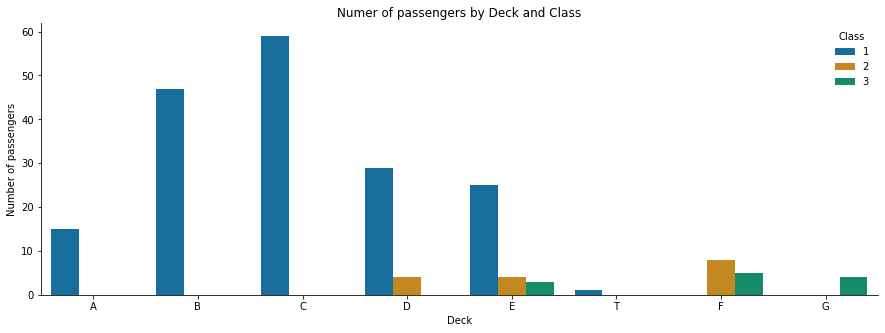

In [73]:
print("\nNumber of passengers by Class with missing values in Cabin:")
display(pd.DataFrame(data=train.groupby(["Pclass"], as_index=False)["Cabin"].apply(lambda x: x.isnull().sum())))

missing_class_deck = train.groupby(["Pclass", "Deck"], as_index=False)["PassengerId"].count()
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x="Deck", y="PassengerId", hue="Pclass", data=missing_class_deck, palette="colorblind")
sns.despine()
ax.set_ylabel("Number of passengers")
ax.set_title("Numer of passengers by Deck and Class")
ax.legend(title="Class", frameon=False)
plt.show()

## Feature distribution

Now, it time to check that the variables are normally distributed, as they can have an impact over model performance, unless we use Tree based models. First, we will explore the distribution of Fare. The distribution show a positive skewness.


Descriptives for Age and Fare


,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200



Descriptives for Fare by Class


Pclass,1,2,3
count,216.000000,184.000000,491.000000
mean,84.154687,20.662183,13.675550
std,78.380373,13.417399,11.778142
min,0.000000,0.000000,0.000000
25%,30.923950,13.000000,7.750000
50%,60.287500,14.250000,8.050000
75%,93.500000,26.000000,15.500000
max,512.329200,73.500000,69.550000


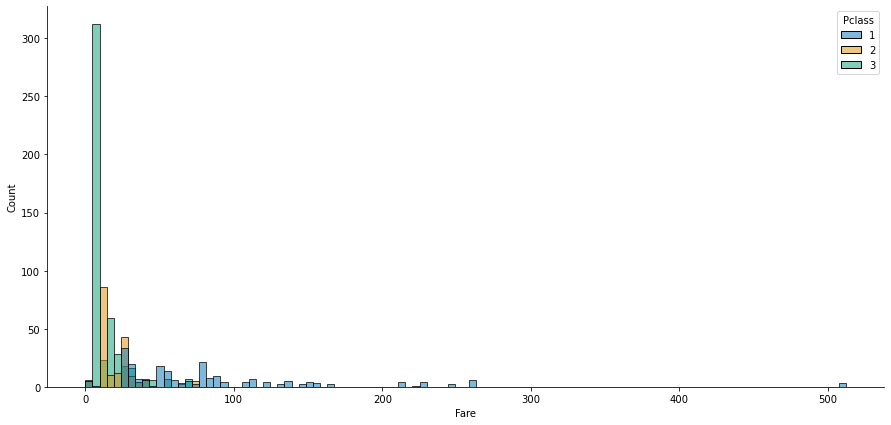

In [74]:
# Age and Fare in the whole sample
print("\nDescriptives for Age and Fare")
display(train[["Age", "Fare"]].describe())

# Fare by class
print("\nDescriptives for Fare by Class")
display(train.groupby(['Pclass'])["Fare"].describe().T)

# plot the distribution of Fare
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data=train, x="Fare", hue="Pclass", palette="colorblind")
sns.despine()
plt.show()

If we zoom into values in the range between 0 and 100, we see that there are First class prices similar to Third class! And the same happens with Second class. Let's print some rows to check this out, specifically for prices below 20$.

Wow, there are 216 tickets priced below 20$ for First class, 184 for Second class and 491! for Third class... how is it possible that Third class paid the same that First class? Could this be something like a group discount? Let's explore it, maybe people with the same ticket have the same price...

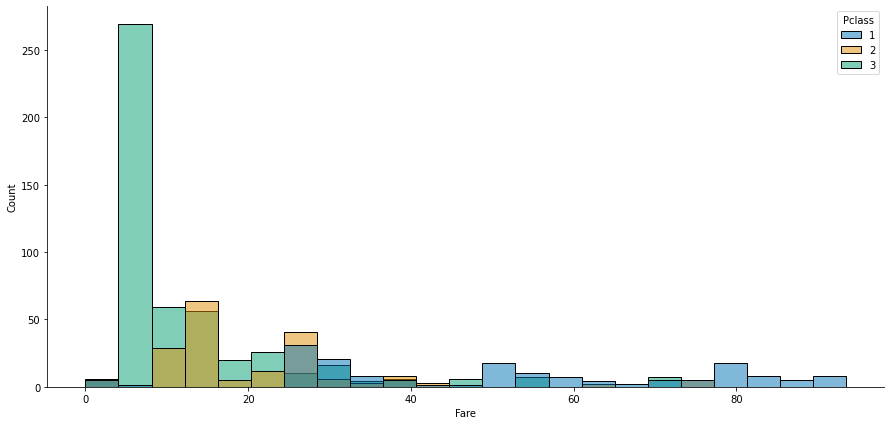

,Pclass,Fare
0,1,216
1,2,184
2,3,491


In [75]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data=train[train["Fare"] < 100], x="Fare", hue="Pclass", palette="colorblind")
sns.despine()
plt.show()

pd.DataFrame(train.groupby(["Pclass"])["Fare"].count()).reset_index()

We can see that those with the same Ticket number have the same "Fare" associated, so this is going to be quite challenging, as it seem unreasonable that First class passengers paid the same price as Third class passengers. 

In [76]:
tickets_numbers = pd.DataFrame(train[train["Fare"] < 20]["Ticket"].value_counts() > 1).reset_index()
tickets_more_than_once = tickets_numbers.loc[tickets_numbers["Ticket"] == True]["index"].to_list()
train.loc[train["Ticket"].isin(tickets_more_than_once)].sort_values(by="Ticket")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section,Title,Passengers_Ticket,Passegers_Cabin
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.00,NaN,S,239853,None,NaN,NaN,Mr,3,NaN
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.00,NaN,S,239853,None,NaN,NaN,Mr,3,NaN
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.00,NaN,S,239853,None,NaN,NaN,Mr,3,NaN
446,447,1,2,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.50,NaN,S,250644,None,NaN,NaN,Miss,2,NaN
272,273,1,2,"Mellinger, Mrs. (Elizabeth Anne Maidment)",female,41.0,0,1,250644,19.50,NaN,S,250644,None,NaN,NaN,Mrs,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.70,G6,S,PP,9549,G,G,Miss,2,4.0
841,842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.50,NaN,S,S.O./P.P.,3,NaN,NaN,Mr,2,NaN
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.50,E77,S,S.O./P.P.,3,E,E,Mrs,2,1.0
142,143,1,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1,0,STON/O2. 3101279,15.85,NaN,S,STON/O2.,3101279,NaN,NaN,Mrs,2,NaN


In [77]:
def normality_tests(df, vars_list):
    
    """
    Checks normality assumptions ussing Kolmogorov-Smirnov (K-S), Shapiro-Wilks (S-W) 
    and D'Agostino-Pearson (D-P).
    
    Input:
        df: DataFrame with data
        vars_list: list of dependent variables to check for normality in the DataFrame.
        
    Output:
        df_NormalityCheck: DataFrame with each dependent variable in a row. Statistics and
                           p-values for each dependent variable for each test.
    """
    
    normality_tests = {'K-S': stats.kstest, 'S-W': stats.shapiro, 'D-P': stats.normaltest}
    normality_dfs = []
    for normal_name, normal_module in normality_tests.items():
        if normal_name == 'K-S':
            df_NormalityCheck = pd.DataFrame(dict([(dv, normal_module(df[dv].dropna(), 'norm')) \
                                                   for dv in vars_list])).rename({0: normal_name, 1: 'p-value ' + 
                                                                                  str(normal_name)}).T
            normality_dfs.append(df_NormalityCheck)
        else:
            df_NormalityCheck = pd.DataFrame(dict([(dv, normal_module(df[dv].dropna())) \
                                                   for dv in vars_list])).rename({0: normal_name, 1: 'p-value ' + 
                                                                                  str(normal_name)}).T
            normality_dfs.append(df_NormalityCheck)
    
    df_NormalityCheck = pd.concat(normality_dfs, axis = 1, sort = False).round(4)
    
    return df_NormalityCheck

In [78]:
def plot_dist(df, dv_list=None, transformation=None):
    """
    Plot distribution of data. If required, a transformation
    of the data could be applied.
    
    Input:
        df: DataFrame
        dv_list: list of variables to be plotted.
        trasnformation (numpy): transformation that wants
                                to be applied to the data.
    Output:
        Distribution plot and probability plot of each variable.
    """
    
    if transformation == None:
        
        if dv_list == None:
            
            df = df
        
        elif dv_list != None:
            
            if len(dv_list) == 1:
                
                df = pd.DataFrame(df[dv_list])
                
            elif len(dv_list) > 1:
                
                df = df[dv_list]
        
        for dv in df.columns:
            fig, ax = plt.subplots(1, 2, figsize=(15,5))
            sns.distplot(df[dv], fit=norm, color='indianred', ax=ax[0])
            stats.probplot(df[dv].dropna(), plot=ax[1])
            plt.show()
        
    elif transformation != None:
        
        if dv_list == None:
            
            df = df.apply(transformation)
            
        elif dv_list != None:
            
            if len(dv_list) == 1:
                
                df = pd.DataFrame(df[dv_list].apply(transformation)) 
                
            elif len(dv_list) > 1:
                
                df = df[dv_list].apply(transformation)
    
        for dv in df.columns:
            fig, ax = plt.subplots(1, 2, figsize=(15,5))
            sns.distplot(df[dv], fit=norm, color='indianred', ax=ax[0])
            stats.probplot(df[dv].dropna(), plot=ax[1])
            plt.show()

### Original distribution

Age seems to have a almost normal distribution, we will try to transform it but this is almost a good approximation to normality. On the other hand, Fare is basically not normally distributed, so we will try to apply some transformations.

,K-S,p-value K-S,S-W,p-value S-W,D-P,p-value D-P
Age,0.9650,0.0,0.9815,0.0,18.1050,0.0001
Fare,0.9831,0.0,0.5219,0.0,904.5873,0.0000


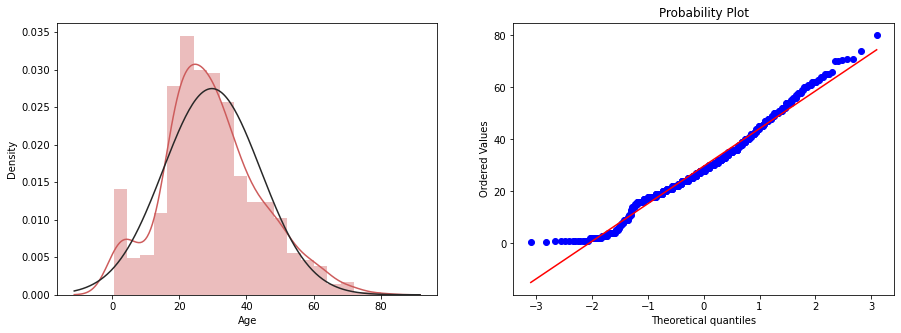

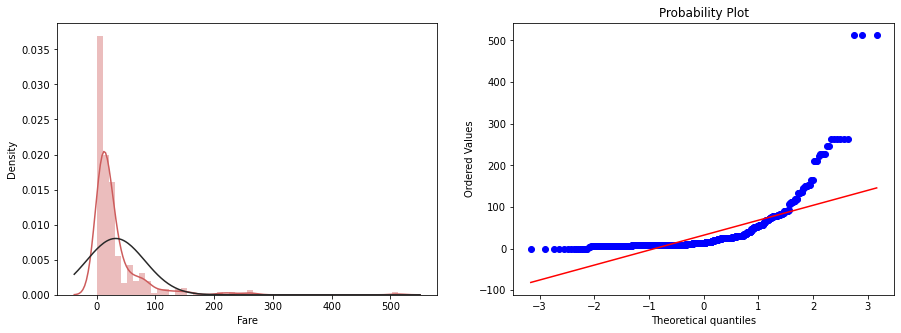

In [79]:
# list of numerical variables
numerical_vars = ["Age", "Fare"]

# normality tests
display(normality_tests(train, numerical_vars))

# plot distribution
plot_dist(train, dv_list=numerical_vars, transformation=None)

After trying several transformations, we have found that Power Transformation implemented in Sklearn, is the one that reduced the skewness in the data. We will apply this transformation into the Logistic Regression, as it could more affected by a non-normal distribution of the features.

We should also consider logarithmic base 10 (+1) transformation, in case we want to modify some transformers in our Pipeline.

### Power Transformation (Yeo-Johnson)

In [157]:
PT_trans = PowerTransformer()
df_power = PT_trans.fit_transform(train[numerical_vars])
df_power = pd.DataFrame(data=df_power, columns=["Age", "Fare"])
display(normality_tests(df_power, numerical_vars))
plot_dist(df=df_power, dv_list=numerical_vars, transformation=None)

NameError: name 'numerical_vars' is not defined

## Custom Transformers

Let's create a the Custom Transformers, so we can apply it to the test dataset in a Pipeline. We can always check model fitting applying only certain transformers.

We are going to take into consideration the following aspects:


* Labels with low frequencies probably affect the robustness of statistical models negatively.


* Labels with a low frequency in a categorical feature will be replaced with a general label like "Other" or "Unknown". In case those labels could be replace with a coherent value, that replacement will take place instead of a general value. This is the case for Decks and Sections T and G that are extracted from the Ticket information, they will be replaced with A and F, as they are the nearests decks, respectively. Also, some titles in the passengers' name have a low frequence (Don, Rev, Count, Dr, etc.), so they will be replaced with a general value "Other".


* This low frequency in some labels could make CV to crash, as once they are transformed into Dummy variables, low frequency variables could land in the train or validation set, and not in both, making the sizes of the sets inconsistent.

### Age Imputer by Passenger Class

In [4]:
class AgeImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        # initiate mean age by passenger class
        self.mean_age_by_class_sex = {}
        #print("Transforming data. In the AgeImputer Transformer init method: ")

    def fit(self, X, y=None):
        # store the mean age by passenger class
        self.mean_age_by_class_sex = X.groupby(["Pclass", "Sex"])["Age"].mean()
        
        return self

    def transform(self, X):
        X = X.copy()        
        # apply values based on dictionaries 
        for pclass_sex, mean_age in self.mean_age_by_class_sex.items():
            X.loc[((X["Age"].isnull()) & (X["Pclass"] == pclass_sex[0]) & (X["Sex"] == pclass_sex[1])), "Age"] = mean_age
        
        #print("Shape in AgeImputer", X.shape)
        
        return X

### Custom Power Transformer

In [5]:
class CustomPowerTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.float_cols = []
        self.pt = PowerTransformer(standardize=False)
        #print('Transforming data. In the CustomStandardizer init method: ')

    def fit(self, X, y=None):
        # list of not dummy cols
        self.float_cols = X.select_dtypes(include=float).columns.to_list()
        self.pt.fit(X[self.float_cols])
        
        return self
    
    def transform(self, X):
        
        X = X.copy()
        # dummy cols df
        X_not_pt = X.drop(columns=self.float_cols).reset_index(drop=True)
        # standardize not dummy cols
        X_trans = self.pt.transform(X[self.float_cols])
        X_trans = pd.DataFrame(data=X_trans, columns=X[self.float_cols].columns)
        
        X_concat = pd.concat([X_not_pt, X_trans], axis=1, join='inner')
        
        return X_concat

### Cabin-Deck-Section Transformer

In [6]:
class CabinDeckSectionUnspecified(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        # regex pattern
        self.pattern = r"^(\D)(\s)(\D)"
        # empty DataFrame
        self.temp_df = {}
        
        #print("Transforming data. In the CabinDeckSectionUnspecified Transformer init method: ")
        
    def fit(self, X, y=None):
        
        # temporary DataFrame extracting Deck and Section from Ticket based on regex pattern
        self.temp_df = X["Cabin"].str.extract(self.pattern).rename(columns={0: "Deck", 1: "whitespace", 2: "Section"})
        
        return self
    
    def transform(self, X):
        
        X = X.copy()
        
        # concatenate DataFrame and pandas Series
        X = X.join(self.temp_df[["Deck", "Section"]])
        
        # where Cabin is null, then Deck will be "Unspecified", otherwise extract information from Cabin
        X["Deck"] = np.where(X["Cabin"].isnull(), "Unspecified", X["Cabin"].str.slice(start=0, stop=1))
        # where Section is null, then replace with Deck value (in this cases Ticket only contains one letter)
        #X["Section"].where(X["Section"].notnull(), X["Deck"], inplace=True, aXis=0)
        X["Section"] = np.where(X["Section"].isnull(), X["Deck"], X["Section"])
        # where Cabin is null, then Section will be "Unspecified"
        X["Section"] = np.where(X["Cabin"].isnull(), "Unspecified", X["Section"])
        # where Cabin is null, then Cabin will be "Unspecified"
        X["Cabin"] = np.where(X["Cabin"].isnull(), "Unspecified", X["Cabin"])
        # where Embarked is null we replace these values from on the internet
        X["Embarked"] = np.where(((X["Cabin"] == "B28") & (X["Embarked"].isnull())), "S",  X["Embarked"])
        # replace class with strings
        X.loc[X["Pclass"] == 1, "Pclass"] = "FirstClass"
        X.loc[X["Pclass"] == 2, "Pclass"] = "SecondClass"
        X.loc[X["Pclass"] == 3, "Pclass"] = "ThirdClass"
        
        # replace low-frequency lables in Deck and Section
        X.loc[X["Deck"] == "T", "Deck"] = "A"
        X.loc[X["Section"] == "T", "Section"] = "A"
        X.loc[X["Deck"] == "G", "Deck"] = "F"
        X.loc[X["Section"] == "G", "Section"] = "F"
        
        #print("Shape in CabinDeckSectionUnspecified", X.shape)
        
        return X

### Most common Deck-Section Imputer

In [7]:
class MostCommonDeckSectionImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.most_common_deck_first_class = {}
        self.most_common_deck_second_class = {}
        self.most_common_deck_third_class = {}
        self.deck_unique_values = {}
        self.section_unique_values = {}
        self.temp_X = None
        self.temp_X_grouped = None
        #print("Transforming data. In the MostCommonDeckSectionImputer Transformer init method: ")

    def fit(self, X, y=None):
        self.temp_X = X[X["Cabin"]  != "Unspecified"]
        self.temp_X_grouped = self.temp_X.groupby(["Pclass", "Deck", "Section"], as_index=False)["PassengerId"].count()
        self.most_common_deck_first_class = self.temp_X_grouped["Deck"].loc[self.temp_X_grouped["PassengerId"] == self.temp_X_grouped.loc[self.temp_X_grouped["Pclass"] == "FirstClass"]["PassengerId"].max()].values[0]
        self.most_common_deck_second_class = self.temp_X_grouped["Deck"].loc[self.temp_X_grouped["PassengerId"] == self.temp_X_grouped.loc[self.temp_X_grouped["Pclass"] == "SecondClass"]["PassengerId"].max()].values[0]
        self.most_common_deck_third_class = self.temp_X_grouped["Deck"].loc[self.temp_X_grouped["PassengerId"] == self.temp_X_grouped.loc[self.temp_X_grouped["Pclass"] == "ThirdClass"]["PassengerId"].max()].values[0]
        self.most_common_section_first_class = self.temp_X_grouped["Section"].loc[self.temp_X_grouped["PassengerId"] == self.temp_X_grouped.loc[self.temp_X_grouped["Pclass"] == "FirstClass"]["PassengerId"].max()].values[0]
        self.most_common_section_second_class = self.temp_X_grouped["Section"].loc[self.temp_X_grouped["PassengerId"] == self.temp_X_grouped.loc[self.temp_X_grouped["Pclass"] == "SecondClass"]["PassengerId"].max()].values[0]
        self.most_common_section_third_class = self.temp_X_grouped["Section"].loc[self.temp_X_grouped["PassengerId"] == self.temp_X_grouped.loc[self.temp_X_grouped["Pclass"] == "ThirdClass"]["PassengerId"].max()].values[0]
        self.deck_unique_values = self.temp_X.groupby(["Deck"])["PassengerId"].nunique().to_dict()
        self.section_unique_values = self.temp_X.groupby(["Section"])["PassengerId"].nunique().to_dict()
        
        return self

    def transform(self, X):
        
        X = X.copy()
        # first, second and third class Cabin null values replace in Deck
        X.loc[((X["Cabin"] == "Unspecified") 
               & (X["Pclass"] == "FirstClass") 
               & (X["Deck"] == "Unspecified")), "Deck"] = self.most_common_deck_first_class
        X.loc[((X["Cabin"] == "Unspecified") 
               & (X["Pclass"] == "SecondClass") 
               & (X["Deck"] == "Unspecified")), "Deck"] = self.most_common_deck_second_class
        X.loc[((X["Cabin"] == "Unspecified") 
               & (X["Pclass"] == "ThirdClass") 
               & (X["Deck"] == "Unspecified")), "Deck"] = self.most_common_deck_third_class
        
        # first, second and third class Cabin null values replace in Section
        X.loc[((X["Cabin"] == "Unspecified") 
               & (X["Pclass"] == "FirstClass") 
               & (X["Section"] == "Unspecified")), "Section"] = self.most_common_section_first_class
        X.loc[((X["Cabin"] == "Unspecified") 
               & (X["Pclass"] == "SecondClass") 
               & (X["Section"] == "Unspecified")), "Section"] = self.most_common_section_second_class
        X.loc[((X["Cabin"] == "Unspecified") 
               & (X["Pclass"] == "ThirdClass") 
               & (X["Section"] == "Unspecified")), "Section"] = self.most_common_section_third_class
        
        # where Cabin is null, then Section will be "Unspecified"
        X["Cabin"] = np.where(X["Cabin"].isnull(), "Unspecified", X["Cabin"])
        
        #print("Shape in MostCommonDeckSectionImputer", X.shape)
        
        return X

### Ticket & Title new features Transformer

In [8]:
class TicketTitle(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        # empty DataFrame
        self.empty = pd.DataFrame()
        # titles list
        self.titles = ["Mr", "Mrs", "Miss", "Master", "Don", "Rev", "Dr", "Mme", "Ms", "Major", 
                       "Mlle", "Col", "Capt", "Lady", "Sir", "Countess", "Count", "Jonkheer"]
        self.title_low_freq = ["Don", "Rev", "Mme", "Ms", "Major", "Lady", "Mlle", "Capt", 
                               "Count", "Jonkheer", "Sir", "Dr", "Col"]
        #print("Transforming data. In the TicketNewFeatures Transformer init method: ")

    def fit(self, X, y=None):
        # split Ticket information based on a whitespace and separate into letter and number
        self.empty = X["Ticket"].str.split(pat=" ", n=1, expand=True).rename(columns={0: "Ticket_L", 1: "Ticket_N"})

        return self

    def transform(self, X):
        
        X = X.copy()
        
        # set titles
        X["Title"] = "None"
        for title in self.titles:
            if title in self.title_low_freq:
                X.loc[X["Name"].str.contains(title), "Title"] = "Other"
            else:
                X.loc[X["Name"].str.contains(title), "Title"] = title
        
        #print("Shape in TicketTitle", X.shape)
        
        return X

### Passengers by Ticket and Cabin Transformer

In [9]:
class PassengersbyTicketCabin(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        # initiate dictionaries
        self.passengers_by_ticket = {}
        self.passenger_by_cabin = {}
        self.pass_by_cabin = None
        #print("Transforming data. In the PassengersbyTicketCabin Transformer init method: ")

    def fit(self, X, y=None):
        
        self.pass_by_cabin = X[X["Cabin"] != "Unspecified"]
        
        # count passengers with the same ticket and in the same cabin
        self.passengers_by_ticket = X.groupby(["Ticket"])["PassengerId"].count()
        self.passenger_by_cabin = self.pass_by_cabin.groupby(["Cabin"])["PassengerId"].count()
        
        return self

    def transform(self, X):
        
        X = X.copy()
        #X["Passengers_Ticket"] = 0
        #X["Passengers_Cabin"] = 0
        # map into DataFrame
        X["Passengers_Ticket"] = X["Ticket"].map(self.passengers_by_ticket)
        X["Passengers_Cabin"] = X["Cabin"].map(self.passenger_by_cabin)
        X.loc[X["Passengers_Ticket"].isnull(), "Passengers_Ticket"] = 0
        X.loc[X["Passengers_Cabin"].isnull(), "Passengers_Cabin"] = 0
        
        X.drop(columns="PassengerId", inplace=True)
        
        #print("Shape in PassengersbyTicketCabin", X.shape)
        #print(X["Passengers_Ticket"].unique())
        #print(X["Passengers_Cabin"].unique())
        
        return X

### Passengers per Cabin Imputer

In [10]:
class PassengerCabinImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        # initiate mean passengers by cabin per class
        self.pass_by_cabin = {}
        #print("Transforming data. In the PassengerCabinImputer Transformer init method: ")

    def fit(self, X, y=None):
        # store the mean number of passengers by Cabin per class
        self.pass_by_cabin = X.groupby(["Pclass"])["Passengers_Cabin"].mean()
        
        return self

    def transform(self, X):
        
        X = X.copy()
        # apply values based on dictionaries 
        for pclass, pass_class in self.pass_by_cabin.items():           
            X.loc[((X["Passengers_Cabin"].isnull()) & (X["Pclass"] == pclass)), "Passengers_Cabin"] = pass_class
        
        #print("Shape in PassengerCabinImputer", X.shape)
        
        return X

### Drop categorial features with more than 100 unique values

In [11]:
class ReduceCategoricalFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, cat_max_num):
        super().__init__()
        self.cat_features = []
        self.cat_to_drop = []
        self.cat_max_num = cat_max_num
        #print("Transforming data. In the ReduceCategorialFeatures Transformer init method: ")

    def fit(self, X, y=None):
        
        self.cat_features = X.select_dtypes(include=object).columns.to_list()
        self.cat_to_drop = [cat for cat in self.cat_features if len(X[cat].unique()) >= self.cat_max_num]
        
        return self

    def transform(self, X):
        
        X = X.copy()
        X_dropped = X.drop(columns=self.cat_to_drop)
        
        #print("Shape in ReduceCategoricalFeatures", X_dropped.shape)
        
        return X_dropped

### Dummy coder

In [12]:
class DummyCustom(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        #print('Transforming data. In the CustomDummy init method: ')

    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X):
           
        X = X.copy()
        X_dummy = pd.get_dummies(X, drop_first=True)
        
        #print("Shape in DummyCustom", X_dummy.shape)
        
        return X_dummy

### Multicollinearity VIF

In [13]:
class MulticollinearityVIF(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.vif = pd.DataFrame()
        self.removed_features = []
        self.df_to_drop = pd.DataFrame()
        #print('Transforming data. In the MulticollinearityVIF init method: ')

    def fit(self, X, y=None):
        self.vif['variables'] = X.columns
        self.vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        self.vif.sort_values(by='VIF', ascending=False, inplace=True)
        
        # deep copy of the original VIF values
        self.vif_original = self.vif.copy(deep=True)
        self.df_to_drop = X.copy(deep=True)
        
        # iterate and removed VIF values greater or equal to 10
        while self.vif['VIF'].iloc[0] >= 10:
            self.df_to_drop.drop(columns=self.vif['variables'].iloc[0], inplace=True)
            self.removed_features.append(self.vif['variables'].iloc[0])
            self.vif = pd.DataFrame()
            self.vif['variables'] = self.df_to_drop.columns
            self.vif['VIF'] = [variance_inflation_factor(self.df_to_drop.values, i) for i in range(self.df_to_drop.shape[1])]
            self.vif.sort_values(by='VIF', ascending=False, inplace=True)
                
        return self
    
    def transform(self, X):
        
        X = X.copy()
        X_vif = X[X.columns[~X.columns.isin(self.removed_features)]]
        
        #print("Shape in MulticollinearityVIF", X_vif.shape)
        
        return X_vif

### Custom Standardizer

In [14]:
class CustomStandardizer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.not_dummy_cols = []
        self.scaler = StandardScaler()
        #print('Transforming data. In the CustomStandardizer init method: ')

    def fit(self, X, y=None):
        # list of not dummy cols
        self.not_dummy_cols = X.select_dtypes(exclude='uint8').columns.to_list()
        self.scaler.fit(X[self.not_dummy_cols])
        
        return self
    
    def transform(self, X):
        
        X = X.copy()
        # dummy cols df
        X_dummy = X.drop(columns=self.not_dummy_cols).reset_index(drop=True)
        # standardize not dummy cols
        X_scaled = self.scaler.transform(X[self.not_dummy_cols])
        X_scaled = pd.DataFrame(data=X_scaled, columns=X[self.not_dummy_cols].columns)
        
        X_concat = pd.concat([X_scaled, X_dummy], axis=1, join='inner')
        
        #print("Shape in CustomStandardizer", X_concat.shape)
        #display(X_concat)
        #display(X_concat.info())
        #display(X_concat.describe())
        
        return X_concat

### Custom Random Forest Selector

In [65]:
class CustomRandomForestSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, max_num_feat):
        super().__init__()
        self.model = RandomForestRegressor(max_depth=10)
        self.selected_features = None
        self.feat_importances = None
        self.max_num_feat = max_num_feat
        print('Transforming data. In the CustomRandomForestSelector init method: ')

    def fit(self, X, y):
        self.model.fit(X, y)
        self.feat_importances = pd.Series(self.model.feature_importances_, index=X.columns)
        #display(feat_importances.sort_values(ascending=False))
        self.selected_features = self.feat_importances.sort_values(ascending=False).nlargest(max_num_feat).index.to_list()
        #print('10 selected features: ')
        #display(self.selected_features)
        
        return self
    
    def transform(self, X, y=None):
        
        X = X[X.columns[X.columns.isin(self.selected_features)]]
        
        return X

## Check correct functioning of Custom Transformers

In [197]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [198]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [201]:
ageimp = AgeImputer()
X_age = ageimp.fit_transform(X_train)
display(X_age.head())
X_age.describe()
X_age.info()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [202]:
X_age.select_dtypes(include=float)

,Age,Fare
0,22.00,7.2500
1,38.00,71.2833
2,26.00,7.9250
3,35.00,53.1000
4,35.00,8.0500
...,...,...
886,27.00,13.0000
887,19.00,30.0000
888,21.75,23.4500
889,26.00,30.0000


In [203]:


ct = CustomPowerTransformer()

X_age_ct = ct.fit_transform(X_age)
X_age_ct

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,Age,Fare
0,1,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,NaN,S,13.166698,1.906724
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C85,C,20.402885,3.497640
2,3,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,NaN,S,15.062740,1.970459
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,C123,S,19.108827,3.304258
4,5,3,"Allen, Mr. William Henry",male,0,0,373450,NaN,S,19.108827,1.981680
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,0,0,211536,NaN,S,15.526249,2.326029
887,888,1,"Graham, Miss. Margaret Edith",female,0,0,112053,B42,S,11.694133,2.916885
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,1,2,W./C. 6607,NaN,S,13.045765,2.745246
889,890,1,"Behr, Mr. Karl Howell",male,0,0,111369,C148,C,15.062740,2.916885


In [204]:
X_age

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.75,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.0000,C148,C


In [69]:
cds = CabinDeckSectionUnspecified()
X_age_cds = cds.fit_transform(X_age)
display(X_age_cds.head())
X_age_cds.shape

Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Shape in CabinDeckSectionUnspecified (891, 13)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Section
0,1,ThirdClass,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unspecified,S,U,U
1,2,FirstClass,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,C
2,3,ThirdClass,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unspecified,S,U,U
3,4,FirstClass,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,C
4,5,ThirdClass,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unspecified,S,U,U


(891, 13)

In [70]:
dsi = MostCommonDeckSectionImputer()
dsi = dsi.fit(X_age_cds)
X_age_cds_dsi = dsi.transform(X_age_cds)
display(X_age_cds_dsi.head())
X_age_cds_dsi.shape

Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Shape in MostCommonDeckSectionImputer (891, 13)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Section
0,1,ThirdClass,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unspecified,S,U,U
1,2,FirstClass,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,C
2,3,ThirdClass,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unspecified,S,U,U
3,4,FirstClass,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,C
4,5,ThirdClass,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unspecified,S,U,U


(891, 13)

In [71]:
X_age_cds_dsi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    object 
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    object 
 10  Embarked     891 non-null    object 
 11  Deck         891 non-null    object 
 12  Section      891 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 90.6+ KB


In [72]:
ticket = TicketTitle()
ticket = ticket.fit(X_age_cds_dsi)
X_age_cds_dsi_ticket = ticket.transform(X_age_cds_dsi)
display(X_age_cds_dsi_ticket.head())
X_age_cds_dsi_ticket.shape
X_age_cds_dsi_ticket.info()

Transforming data. In the TicketNewFeatures Transformer init method: 
Shape in TicketTitle (891, 14)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Section,Title
0,1,ThirdClass,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unspecified,S,U,U,Mr
1,2,FirstClass,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,C,Mrs
2,3,ThirdClass,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unspecified,S,U,U,Miss
3,4,FirstClass,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,C,Mrs
4,5,ThirdClass,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unspecified,S,U,U,Mr


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    object 
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    object 
 10  Embarked     891 non-null    object 
 11  Deck         891 non-null    object 
 12  Section      891 non-null    object 
 13  Title        891 non-null    object 
dtypes: float64(2), int64(3), object(9)
memory usage: 97.6+ KB


In [73]:
Counter(X_age_cds_dsi_ticket["Title"])

Counter({'Mr': 506, 'Mrs': 123, 'Miss': 180, 'Master': 40, 'Other': 42})

In [116]:
pcabin = PassengersbyTicketCabin()
pcabin = pcabin.fit(X_age_cds_dsi_ticket)
X_age_cds_dsi_ticket_pass = pcabin.transform(X_age_cds_dsi_ticket)
display(X_age_cds_dsi_ticket_pass.head())
X_age_cds_dsi_ticket_pass.shape
X_age_cds_dsi_ticket_pass.info()

Transforming data. In the PassengersbyTicketCabin Transformer init method: 
Shape in PassengersbyTicketCabin (891, 15)
[1 2 4 3 7 5 6]
[nan  1.  2.  4.  3.]


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Section,Title,Passengers_Ticket,Passengers_Cabin
0,ThirdClass,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unspecified,S,F,F,Mr,1,NaN
1,FirstClass,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,C,Mrs,1,1.0
2,ThirdClass,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unspecified,S,F,F,Miss,1,NaN
3,FirstClass,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,C,Mrs,2,2.0
4,ThirdClass,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unspecified,S,F,F,Mr,1,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pclass             891 non-null    object 
 1   Name               891 non-null    object 
 2   Sex                891 non-null    object 
 3   Age                891 non-null    float64
 4   SibSp              891 non-null    int64  
 5   Parch              891 non-null    int64  
 6   Ticket             891 non-null    object 
 7   Fare               891 non-null    float64
 8   Cabin              891 non-null    object 
 9   Embarked           891 non-null    object 
 10  Deck               891 non-null    object 
 11  Section            891 non-null    object 
 12  Title              891 non-null    object 
 13  Passengers_Ticket  891 non-null    int64  
 14  Passengers_Cabin   204 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 104.5+ KB


In [122]:
X_age_cds_dsi_ticket_pass.loc[(X_age_cds_dsi_ticket_pass["Passengers_Cabin"].isnull()), "Passengers_Cabin"] = 0
X_age_cds_dsi_ticket_pass["Passengers_Cabin"].unique()

array([0., 1., 2., 4., 3.])

In [104]:
X_age_cds_dsi_ticket_pass["Passengers_Cabin"][0].dtype

TypeError: 'int' object is not subscriptable

In [87]:
z = np.where(X_age_cds_dsi_ticket_pass["Passengers_Cabin"] == np.nan, 0, X_age_cds_dsi_ticket_pass["Passengers_Cabin"])
z

array([nan,  1., nan,  2., nan, nan,  1., nan, nan, nan,  4.,  1., nan,
       nan, nan, nan, nan, nan, nan, nan, nan,  1., nan,  1., nan, nan,
       nan,  4., nan, nan, nan,  1., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        2., nan,  1.,  2., nan, nan, nan, nan, nan,  2.,  2., nan, nan,
       nan,  3., nan, nan, nan, nan, nan, nan, nan, nan,  2., nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  4., nan, nan,
       nan,  1., nan, nan, nan,  1.,  1., nan, nan, nan, nan,  2., nan,
       nan, nan, nan, nan, nan, nan,  1., nan, nan, nan, nan, nan, nan,
       nan,  2., nan, nan, nan, nan,  3.,  2., nan, nan, nan,  1., nan,
       nan, nan, nan, nan, nan, nan,  1.,  2., nan,  1., nan, nan, nan,
       nan, nan, nan, nan, nan,  3., nan, nan,  2., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  2., nan, nan,
       nan,  1., nan, nan, nan,  1., nan, nan,  1., nan, nan, na

In [50]:
pcimp = PassengerCabinImputer()
pcimp = pcimp.fit(X_age_cds_dsi_ticket_pass)
X_age_cds_dsi_ticket_pass_pcimp = pcimp.transform(X_age_cds_dsi_ticket_pass)
display(X_age_cds_dsi_ticket_pass_pcimp.head())
X_age_cds_dsi_ticket_pass_pcimp.shape
X_age_cds_dsi_ticket_pass_pcimp.info()

Transforming data. In the PassengerCabinImputer Transformer init method: 


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Section,Deck,Ticket_L,Ticket_N,Title,Passengers_Ticket,Passegers_Cabin
0,1,ThirdClass,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unspecified,S,F,F,A/5,21171,Mr,1,2.333333
1,2,FirstClass,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,C,PC,17599,Mrs,1,1.000000
2,3,ThirdClass,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unspecified,S,F,F,STON/O2.,3101282,Miss,1,2.333333
3,4,FirstClass,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,C,113803,None,Mrs,2,2.000000
4,5,ThirdClass,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unspecified,S,F,F,373450,None,Mr,1,2.333333


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Pclass             891 non-null    object 
 2   Name               891 non-null    object 
 3   Sex                891 non-null    object 
 4   Age                891 non-null    float64
 5   SibSp              891 non-null    int64  
 6   Parch              891 non-null    int64  
 7   Ticket             891 non-null    object 
 8   Fare               891 non-null    float64
 9   Cabin              891 non-null    object 
 10  Embarked           889 non-null    object 
 11  Section            891 non-null    object 
 12  Deck               891 non-null    object 
 13  Ticket_L           891 non-null    object 
 14  Ticket_N           226 non-null    object 
 15  Title              891 non-null    object 
 16  Passengers_Ticket  891 non

In [53]:
rcf = ReduceCategoricalFeatures(cat_max_num = 100)
rcf = rcf.fit(X_age_cds_dsi_ticket_pass_pcimp)
X_age_cds_dsi_ticket_pass_pcimp_rcf = rcf.transform(X_age_cds_dsi_ticket_pass_pcimp)
display(X_age_cds_dsi_ticket_pass_pcimp_rcf.head())
X_age_cds_dsi_ticket_pass_pcimp_rcf.shape

Transforming data. In the ReduceCategorialFeatures Transformer init method: 


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Section,Deck,Title,Passengers_Ticket,Passegers_Cabin
0,1,ThirdClass,male,22.0,1,0,7.2500,S,F,F,Mr,1,2.333333
1,2,FirstClass,female,38.0,1,0,71.2833,C,C,C,Mrs,1,1.000000
2,3,ThirdClass,female,26.0,0,0,7.9250,S,F,F,Miss,1,2.333333
3,4,FirstClass,female,35.0,1,0,53.1000,S,C,C,Mrs,2,2.000000
4,5,ThirdClass,male,35.0,0,0,8.0500,S,F,F,Mr,1,2.333333


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Section,Deck,Title,Passengers_Ticket,Passegers_Cabin
61,62,FirstClass,female,38.0,0,0,80.0,NaN,B,B,Miss,2,2.0
829,830,FirstClass,female,62.0,0,0,80.0,NaN,B,B,Mrs,2,2.0


In [55]:
dummy = CustomDummy()
dummy = dummy.fit(X_age_cds_dsi_ticket_pass_pcimp_rcf)
X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy = dummy.transform(X_age_cds_dsi_ticket_pass_pcimp_rcf)
display(X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy.head())
X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy.shape
X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy.iloc[61]

Transforming data. In the CustomDummy init method: 


,PassengerId,Age,SibSp,Parch,Fare,Passengers_Ticket,Passegers_Cabin,Pclass_SecondClass,Pclass_ThirdClass,Sex_male,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,1,22.0,1,0,7.2500,1,2.333333,0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,2,38.0,1,0,71.2833,1,1.000000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,26.0,0,0,7.9250,1,2.333333,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,4,35.0,1,0,53.1000,2,2.000000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,35.0,0,0,8.0500,1,2.333333,0,1,1,...,0,0,0,0,0,1,0,0,0,0


PassengerId           62.0
Age                   38.0
SibSp                  0.0
Parch                  0.0
Fare                  80.0
Passengers_Ticket      2.0
Passegers_Cabin        2.0
Pclass_SecondClass     0.0
Pclass_ThirdClass      0.0
Sex_male               0.0
Embarked_Q             0.0
Embarked_S             0.0
Section_B              1.0
Section_C              0.0
Section_D              0.0
Section_E              0.0
Section_F              0.0
Section_G              0.0
Section_T              0.0
Deck_B                 1.0
Deck_C                 0.0
Deck_D                 0.0
Deck_E                 0.0
Deck_F                 0.0
Deck_G                 0.0
Deck_T                 0.0
Title_Col              0.0
Title_Count            0.0
Title_Don              0.0
Title_Dr               0.0
Title_Jonkheer         0.0
Title_Lady             0.0
Title_Major            0.0
Title_Master           0.0
Title_Miss             1.0
Title_Mlle             0.0
Title_Mme              0.0
T

In [141]:
vif = MulticollinearityVIF()
vif = vif.fit(X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy)
X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif = vif.transform(X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy)
display(X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif.head())
X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif.shape

Transforming data. In the MulticollinearityVIF init method: 


,PassengerId,Age,SibSp,Parch,Fare,Passengers_Ticket,Pclass_SecondClass,Pclass_ThirdClass,Embarked_Q,Embarked_S,...,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,1,22.0,1,0,7.2500,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,38.0,1,0,71.2833,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,26.0,0,0,7.9250,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,4,35.0,1,0,53.1000,2,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,5,35.0,0,0,8.0500,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


(891, 32)

In [191]:
X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         891 non-null    int64  
 1   Age                 891 non-null    float64
 2   SibSp               891 non-null    int64  
 3   Parch               891 non-null    int64  
 4   Fare                891 non-null    float64
 5   Passengers_Ticket   891 non-null    int64  
 6   Pclass_SecondClass  891 non-null    uint8  
 7   Pclass_ThirdClass   891 non-null    uint8  
 8   Embarked_Q          891 non-null    uint8  
 9   Embarked_S          891 non-null    uint8  
 10  Deck_B              891 non-null    uint8  
 11  Deck_C              891 non-null    uint8  
 12  Deck_D              891 non-null    uint8  
 13  Deck_E              891 non-null    uint8  
 14  Deck_G              891 non-null    uint8  
 15  Section_G           891 non-null    uint8  
 16  Section_

In [142]:
stand = CustomStandardizer()
stand = stand.fit(X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif)
X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif_stand = stand.transform(X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif)
display(X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif_stand.head())
X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif_stand.shape

Transforming data. In the CustomStandardizer init method: 


,PassengerId,Age,SibSp,Parch,Fare,Passengers_Ticket,Pclass_SecondClass,Pclass_ThirdClass,Embarked_Q,Embarked_S,...,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,-1.730108,-0.551366,0.432793,-0.473674,-0.502445,-0.579162,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,-1.726220,0.654030,0.432793,-0.473674,0.786845,-0.579162,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-1.722332,-0.250017,-0.474545,-0.473674,-0.488854,-0.579162,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,-1.718444,0.428018,0.432793,-0.473674,0.420730,0.155928,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,-1.714556,0.428018,-0.474545,-0.473674,-0.486337,-0.579162,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


(891, 32)

In [149]:
scaler = StandardScaler()


not_dummy_cols = X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif.select_dtypes(exclude='uint8').columns.to_list()
scaler.fit(X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif[not_dummy_cols])
        
X_dummy = X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif.drop(columns=not_dummy_cols).reset_index(drop=True)

X_scaled = scaler.transform(X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif[not_dummy_cols])
X_scaled = pd.DataFrame(data=X_scaled, columns=X_age_cds_dsi_ticket_pass_pcimp_rcf_dummy_vif[not_dummy_cols].columns)
        
#X = pd.concat([X_scaled, X_dummy], axis=1)

In [150]:
X_dummy

,Pclass_SecondClass,Pclass_ThirdClass,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_G,Section_G,...,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
887,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
888,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
889,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
X_scaled

,PassengerId,Age,SibSp,Parch,Fare,Passengers_Ticket
0,-1.730108,-0.551366,0.432793,-0.473674,-0.502445,-0.579162
1,-1.726220,0.654030,0.432793,-0.473674,0.786845,-0.579162
2,-1.722332,-0.250017,-0.474545,-0.473674,-0.488854,-0.579162
3,-1.718444,0.428018,0.432793,-0.473674,0.420730,0.155928
4,-1.714556,0.428018,-0.474545,-0.473674,-0.486337,-0.579162
...,...,...,...,...,...,...
886,1.714556,-0.174680,-0.474545,-0.473674,-0.386671,-0.579162
887,1.718444,-0.777378,-0.474545,-0.473674,-0.044381,-0.579162
888,1.722332,-0.570201,0.432793,2.008933,-0.176263,0.155928
889,1.726220,-0.250017,-0.474545,-0.473674,-0.044381,-0.579162


In [155]:
X = pd.concat([X_scaled, X_dummy], axis=1, join='inner')
X

,PassengerId,Age,SibSp,Parch,Fare,Passengers_Ticket,Pclass_SecondClass,Pclass_ThirdClass,Embarked_Q,Embarked_S,...,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,-1.730108,-0.551366,0.432793,-0.473674,-0.502445,-0.579162,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,-1.726220,0.654030,0.432793,-0.473674,0.786845,-0.579162,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-1.722332,-0.250017,-0.474545,-0.473674,-0.488854,-0.579162,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,-1.718444,0.428018,0.432793,-0.473674,0.420730,0.155928,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,-1.714556,0.428018,-0.474545,-0.473674,-0.486337,-0.579162,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1.714556,-0.174680,-0.474545,-0.473674,-0.386671,-0.579162,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
887,1.718444,-0.777378,-0.474545,-0.473674,-0.044381,-0.579162,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
888,1.722332,-0.570201,0.432793,2.008933,-0.176263,0.155928,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
889,1.726220,-0.250017,-0.474545,-0.473674,-0.044381,-0.579162,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection

### F Classification

In [32]:
f, p_vals = f_classif(X_train_transf, y_train)
f_classif_feat = pd.DataFrame(data={"F_value": f, "p_values": np.round(p_vals, 3), 
                                    "Feature": X_train_transf.columns.to_list()}).sort_values(by="p_values")

In [33]:
sel_fclassif = SelectKBest(f_classif, k=15)
X_train_selected = sel_fclassif.fit_transform(X_train_transf, y_train)
#print(sel_fclassif.get_support())

sel_f_classif = pd.DataFrame(data={"Feature": X_train_transf.columns.to_list(),
                                   "Support": sel_fclassif.get_support(),
                                   "Scores": sel_fclassif.scores_,
                                   "p_values": np.round(sel_fclassif.pvalues_, 3)}).sort_values(by="Support", ascending=False)

In [34]:
sel_f_classif

,Feature,Support,Scores,p_values
0,Age,True,4.067226,0.044
9,Deck_B,True,28.117228,0.000
23,Title_Master,True,6.503635,0.011
24,Title_Miss,True,102.381246,0.000
25,Title_Mlle,True,3.222163,0.073
27,Title_Mrs,True,110.946796,0.000
12,Deck_E,True,19.179221,0.000
11,Deck_D,True,20.663186,0.000
10,Deck_C,True,12.444444,0.000
8,Embarked_S,True,22.075469,0.000


### Chi square

In [106]:
ch, p_vals_ch = chi2(X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif, y)
chi2_classif = pd.DataFrame(data={"Chi2_value": ch, 
                                  "p_values": np.round(p_vals_ch, 3), 
                                  "Feature": X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif.columns.to_list()}).sort_values(by="p_values")

In [136]:
sel_chi2 = SelectKBest(chi2, k=15)
X_train = sel_chi2.fit_transform(X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif, y)

sel_chi2_classif = pd.DataFrame(data={"Feature": X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif.columns.to_list(),
                                      "Support": sel_chi2.get_support(),
                                      "Scores": sel_chi2.scores_,
                                      "p_values": np.round(sel_chi2.pvalues_, 3)}).sort_values(by="Support", ascending=False)

### Mutual Information Classification

In [108]:
mi = mutual_info_classif(X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif, y)
mi_classif = pd.DataFrame(data={"Mutual_Information_Classification": mi, 
                                "Feature": X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif.columns.to_list()}).sort_values(by="Mutual_Information_Classification", ascending=False)

In [145]:
sel_mi = SelectKBest(mutual_info_classif, k=15)
X_train = sel_mi.fit_transform(X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif, y)

sel_mi = pd.DataFrame(data={"Feature": X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif.columns.to_list(),
                            "Support": sel_mi.get_support(),
                            "Scores": sel_mi.scores_}).sort_values(by="Support", ascending=False)

### Recursive Feature Elimination + Random Forest Classifier

In [124]:
model = RandomForestClassifier()
rfe = RFE(model, 15)
fit = rfe.fit(X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif, y)
#print("Num Features: %d" % fit.n_features_)
#print("Selected Features: %s" % fit.support_)
#print("Feature Ranking: %s" % fit.ranking_)

rfe_rfc = pd.DataFrame(data={"Feature": X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif.columns.to_list(),
                             "Support": fit.support_,
                             "Ranking": fit.ranking_}).sort_values(by="Support", ascending=False)

### Recursive Feature Elimination + Logistic Regression

In [121]:
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 15)
fit = rfe.fit(X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif, y)
#print("Num Features: %d" % fit.n_features_)
#print("Selected Features: %s" % fit.support_)
#print("Feature Ranking: %s" % fit.ranking_)

rfe_lr = pd.DataFrame(data={"Feature": X_age_cds_dsi_ticket_title_pass_pcimp_rcf_dummy_vif.columns.to_list(),
                            "Support": fit.support_,
                            "Ranking": fit.ranking_}).sort_values(by="Support", ascending=False)

### Check feature selected by different methods

In [131]:
f_classif_feat[f_classif_feat["p_values"] < .1]

,F_value,p_values,Feature
28,110.946796,0.000,Title_Mrs
13,19.179221,0.000,Deck_E
11,12.444444,0.000,Deck_C
10,28.117228,0.000,Deck_B
9,22.075469,0.000,Embarked_S
7,103.057599,0.000,Pclass_ThirdClass
12,20.663186,0.000,Deck_D
25,102.381246,0.000,Title_Miss
4,63.030764,0.000,Fare
6,7.814805,0.005,Pclass_SecondClass


In [146]:
sel_f_classif[sel_f_classif["Support"] == True]

,Feature,Support,Scores,p_values
10,Deck_B,True,28.117228,0.000
1,Age,True,2.273293,0.132
30,Title_Rev,True,3.770523,0.052
3,Parch,True,5.963464,0.015
4,Fare,True,63.030764,0.000
6,Pclass_SecondClass,True,7.814805,0.005
7,Pclass_ThirdClass,True,103.057599,0.000
28,Title_Mrs,True,110.946796,0.000
9,Embarked_S,True,22.075469,0.000
24,Title_Master,True,6.503635,0.011


In [147]:
chi2_classif[chi2_classif["p_values"] < .1]

,Chi2_value,p_values,Feature
13,18.140638,0.000,Deck_E
1,13.524238,0.000,Age
4,4518.319091,0.000,Fare
7,41.553071,0.000,Pclass_ThirdClass
28,85.211673,0.000,Title_Mrs
10,25.875581,0.000,Deck_B
12,19.489646,0.000,Deck_D
25,73.425906,0.000,Title_Miss
3,10.097499,0.001,Parch
11,10.933563,0.001,Deck_C


In [148]:
sel_chi2_classif[sel_chi2_classif["Support"] == True]

,Feature,Support,Scores,p_values
0,PassengerId,True,3.312934,0.069
9,Embarked_S,True,5.984840,0.014
24,Title_Master,True,6.180425,0.013
25,Title_Miss,True,73.425906,0.000
1,Age,True,13.524238,0.000
13,Deck_E,True,18.140638,0.000
12,Deck_D,True,19.489646,0.000
11,Deck_C,True,10.933563,0.001
10,Deck_B,True,25.875581,0.000
28,Title_Mrs,True,85.211673,0.000


In [149]:
mi_classif[mi_classif["Mutual_Information_Classification"] > 0]

,Mutual_Information_Classification,Feature
4,0.132336,Fare
28,0.069546,Title_Mrs
5,0.061675,Passengers_Ticket
25,0.054147,Title_Miss
12,0.039865,Deck_D
7,0.034233,Pclass_ThirdClass
2,0.029367,SibSp
13,0.023263,Deck_E
1,0.022494,Age
24,0.016740,Title_Master


In [150]:
sel_mi[sel_mi["Support"] == True]

,Feature,Support,Scores
0,PassengerId,True,0.017945
28,Title_Mrs,True,0.026268
18,Title_Count,True,0.040688
25,Title_Miss,True,0.041137
26,Title_Mlle,True,0.016492
13,Deck_E,True,0.015410
12,Deck_D,True,0.041538
11,Deck_C,True,0.017120
10,Deck_B,True,0.033117
7,Pclass_ThirdClass,True,0.062527


In [125]:
rfe_rfc[rfe_rfc["Support"] == True]

,Feature,Support,Ranking
0,PassengerId,True,1
9,Embarked_S,True,1
24,Title_Master,True,1
25,Title_Miss,True,1
1,Age,True,1
28,Title_Mrs,True,1
13,Deck_E,True,1
11,Deck_C,True,1
10,Deck_B,True,1
7,Pclass_ThirdClass,True,1


In [123]:
rfe_lr[rfe_lr["Support"] == True]

,Feature,Support,Ranking
9,Embarked_S,True,1
19,Title_Don,True,1
20,Title_Dr,True,1
22,Title_Lady,True,1
13,Deck_E,True,1
12,Deck_D,True,1
24,Title_Master,True,1
10,Deck_B,True,1
18,Title_Count,True,1
25,Title_Miss,True,1


## Pipeline

https://www.datacamp.com/community/tutorials/feature-selection-python

Simply speaking, you should include the feature selection step before feeding the data to the model for training especially when you are using accuracy estimation methods such as **cross-validation**. This ensures that feature selection is performed on the data fold right before the model is trained. **But if you perform feature selection first to prepare your data, then perform model selection and training on the selected features then it would be a blunder.**

If you perform feature selection on all of the data and then cross-validate, then the test data in each fold of the cross-validation procedure was also used to choose the features, and this tends to bias the performance of your machine learning model.

### Baseline without cross-validation

In [15]:
ft_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer())])

# fit and transform the data
X_train_transf = ft_pipeline.fit_transform(X_train, y_train)
#X_train_transf.drop(columns="PassengerId", inplace=True)

# compute ROC_AUC score for each model using the transformed data
lr_cross_val_scores = cross_val_score(estimator=LogisticRegression(), X=X_train_transf, y=y_train, scoring="roc_auc", cv=5)
xgb_cross_val_scores = cross_val_score(estimator=xgb.XGBClassifier(), X=X_train_transf, y=y_train, scoring="roc_auc", cv=5)
rfc_cross_val_scores = cross_val_score(estimator=RandomForestClassifier(), X=X_train_transf, y=y_train, scoring="roc_auc", cv=5)
gbc_cross_val_scores = cross_val_score(estimator=GradientBoostingClassifier(), X=X_train_transf, y=y_train, scoring="roc_auc", cv=5)

print("\n Logistic Regression ROC_AUC:", lr_cross_val_scores.mean().round(5), "\n",
      "XGB Classifier ROC_AUC:", xgb_cross_val_scores.mean().round(5), "\n",
      "Random Forest Classifier ROC_AUC:", rfc_cross_val_scores.mean().round(5), "\n",
      "Gradient Boosting Classifier ROC_AUC:", gbc_cross_val_scores.mean().round(5))

[21:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:16:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Baseline with cross-validation

In [135]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=False)

lr_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("lr_model", LogisticRegression())])

xgb_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("xgb_model", xgb.XGBClassifier())])

rfc_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("rcf_model", RandomForestClassifier())])

gbc_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("gbc_model", GradientBoostingClassifier())])


# compute ROC_AUC score for each model using the transformed data
lr_cross_val_scores = cross_val_score(estimator=lr_pipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)
xgb_cross_val_scores = cross_val_score(estimator=xgb_pipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)
rfc_cross_val_scores = cross_val_score(estimator=rfc_pipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)
gbc_cross_val_scores = cross_val_score(estimator=gbc_pipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)

print("\n Logistic Regression ROC_AUC:", lr_cross_val_scores.mean().round(5), "\n",
      "XGB Classifier ROC_AUC:", xgb_cross_val_scores.mean().round(5), "\n",
      "Random Forest Classifier ROC_AUC:", rfc_cross_val_scores.mean().round(5), "\n",
      "Gradient Boosting Classifier ROC_AUC:", gbc_cross_val_scores.mean().round(5))

[20:56:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Balance data applying SMOTE

Let's try applying some SMOTE as the data could be imbalanced, we have 549 cases that ended in death, and 342 that ended in survival.

In [147]:
Counter(y_train)

Counter({0: 549, 1: 342})

In [184]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from imblearn.combine import SMOTEENN 
from sklearn.metrics import f1_score
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
kfold = StratifiedKFold(n_splits=5, shuffle=False)


lr_imbpipeline = ImbPipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("smote", SMOTE()),
                        ("lr_model", LogisticRegression())])

xgb_imbpipeline = ImbPipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("smote", SMOTE()),
                        ("xgb_model", xgb.XGBClassifier())])

rfc_imbpipeline = ImbPipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("smote", SMOTE()),
                        ("rcf_model", RandomForestClassifier())])

gbc_imbpipeline = ImbPipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("smote", SMOTE()),
                        ("gbc_model", GradientBoostingClassifier())])


# compute ROC_AUC score for each model using the transformed data
lr_cross_val_scores = cross_val_score(estimator=lr_imbpipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)
xgb_cross_val_scores = cross_val_score(estimator=xgb_imbpipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)
rfc_cross_val_scores = cross_val_score(estimator=rfc_imbpipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)
gbc_cross_val_scores = cross_val_score(estimator=gbc_imbpipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)

print("\n Logistic Regression ROC_AUC:", lr_cross_val_scores.mean().round(5), "\n",
      "XGB Classifier ROC_AUC:", xgb_cross_val_scores.mean().round(5), "\n",
      "Random Forest Classifier ROC_AUC:", rfc_cross_val_scores.mean().round(5), "\n",
      "Gradient Boosting Classifier ROC_AUC:", gbc_cross_val_scores.mean().round(5))

[22:15:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Baseline with GridSearchCV

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=False)

ft_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("ct", CustomPowerTransformer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("lr_model", LogisticRegression())])


lr_param_grid = {"lr_model__C": np.logspace(-4, 4, 20), 
                 "lr_model__penalty": ["l1", "l2"]}

logreg_cv = GridSearchCV(estimator=ft_pipeline, # pipeline with the model at the end
                         param_grid=lr_param_grid, # parameters grid
                         scoring="roc_auc",
                         cv=5)

logreg_cv.fit(X_train, y_train)
print("Tuned hpyerparameters (best parameters):", logreg_cv.best_params_)
print("ROC_AUC best score:", logreg_cv.best_score_)

best_logreg = logreg_cv.fit(X_train, y_train)


# XGBoost

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

Tuned hpyerparameters (best parameters): {'lr_model__C': 1.623776739188721, 'lr_model__penalty': 'l2'}
ROC_AUC best score: 0.8493136739411289


### Include Power Transformation into the Pipeline

In [208]:
lr_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("ct", CustomPowerTransformer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("lr_model", LogisticRegression())])

xgb_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("ct", CustomPowerTransformer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("xgb_model", xgb.XGBClassifier())])

rfc_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("ct", CustomPowerTransformer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("rcf_model", RandomForestClassifier())])

gbc_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("ct", CustomPowerTransformer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", DummyCustom()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("gbc_model", GradientBoostingClassifier())])


# compute ROC_AUC score for each model using the transformed data
lr_cross_val_scores = cross_val_score(estimator=lr_pipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)
xgb_cross_val_scores = cross_val_score(estimator=xgb_pipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)
rfc_cross_val_scores = cross_val_score(estimator=rfc_pipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)
gbc_cross_val_scores = cross_val_score(estimator=gbc_pipeline, X=X_train, y=y_train, scoring="roc_auc", cv=kfold)

print("\n Logistic Regression ROC_AUC:", lr_cross_val_scores.mean().round(5), "\n",
      "XGB Classifier ROC_AUC:", xgb_cross_val_scores.mean().round(5), "\n",
      "Random Forest Classifier ROC_AUC:", rfc_cross_val_scores.mean().round(5), "\n",
      "Gradient Boosting Classifier ROC_AUC:", gbc_cross_val_scores.mean().round(5))

[22:39:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Feature Selection into the Pipeline

Perform Feature Selection with Random Forest

In [22]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
dtrain = xgb.DMatrix(X_train_np, label=y_train_np)
#dtest = xgb.DMatrix(X_test, label=y_test)

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

# Models

## Logistic Regression

In [72]:
lr_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", CustomDummy()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("lr_model", LogisticRegression())]) # specify model here

# no GridSearchCV

lr_pipeline.fit(X_train, y_train) # X train unstransformed data
lr_pipeline.score(X_train, y_train)
lr_pipeline.predict(X_train)

Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming data. In the PassengersbyTicketCabin Transformer init method: 
Transforming data. In the PassengerCabinImputer Transformer init method: 
Transforming data. In the ReduceCategorialFeatures Transformer init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 


array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,

In [56]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.75,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.0000,C148,C


In [86]:
lr_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", CustomDummy()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("lr_model", LogisticRegression())]) # specify model here


lr_param_grid = {"lr_model__C": np.logspace(-3, 3, 7), 
                 "lr_model__penalty": ["l1", "l2"]}

logreg_cv = GridSearchCV(estimator=lr_pipeline, # pipeline with the model at the end
                         param_grid=lr_param_grid, # parameters grid
                         scoring="roc_auc",
                         cv=5)

logreg_cv.fit(X_train, y_train)
#print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
#print("accuracy :", logreg_cv.best_score_)

Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming data. In the PassengersbyTicketCabin Transformer init method: 
Transforming data. In the PassengerCabinImputer Transformer init method: 
Transforming data. In the ReduceCategorialFeatures Transformer init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming 

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by StandardScaler.

In [61]:
# CV if we use LogisticRegressionCV

from sklearn.linear_model import LogisticRegressionCV

lr_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", CustomDummy()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("lr_model", LogisticRegressionCV(cv=5, scoring="roc_auc"))])

lr_pipeline.fit(X_train, y_train)
lr_pipeline.score(X_train, y_train)

Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming data. In the PassengersbyTicketCabin Transformer init method: 
Transforming data. In the PassengerCabinImputer Transformer init method: 
Transforming data. In the ReduceCategorialFeatures Transformer init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 


0.8769213562138498

In [70]:
lr_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", CustomDummy()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("lr_model", LogisticRegressionCV(scoring="roc_auc"))])

lr_param_grid = {"lr_model__Cs": np.logspace(-3, 3, 7), 
                 "lr_model__penalty": ["l2"]}

logreg_cv = GridSearchCV(estimator=lr_pipeline,
                         param_grid=lr_param_grid, 
                         scoring="roc_auc",
                         cv=5)

logreg_cv.fit(X_train, y_train)

Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming data. In the PassengersbyTicketCabin Transformer init method: 
Transforming data. In the PassengerCabinImputer Transformer init method: 
Transforming data. In the ReduceCategorialFeatures Transformer init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming 

TypeError: object of type 'numpy.float64' has no len()

In [145]:
lr_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", CustomDummy()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("lr_model", LogisticRegression())])


#model_pipeline = Pipeline([("lr_model", LogisticRegression())])
#
#general_pipeline = FeatureUnion([("data_transform", tr_pipeline),
#                                  ("model", model_pipeline)])

cross_val_scores = cross_val_score(estimator=lr_pipeline, X=X_train, y=y_train_reshape, scoring="roc_auc", cv=5)

#grid_params = {"lr_model__penalty": ["l1", "l2", "elasticnet"]}

#gs_lr = GridSearchCV(estimator=lr_pipeline,
#                     param_grid=grid_params,
#                     cv=5,
#                     return_train_score=True)

#gs_lr.fit(X_train, y_train)

Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 


NameError: name 'TicketTitle' is not defined

In [20]:
lr_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket_title", TicketTitle()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", CustomDummy()),
                        ("vif", MulticollinearityVIF()),
                        ("scaler", CustomStandardizer()),
                        ("lr_model", LogisticRegression())])


lr_param_grid = {"lr_model__penalty": ["l1", "l2"],
                 "lr_model__C": [0.1, 1.0, 10.0, 100.0],
                 "lr_model": [LogisticRegression()]}

logreg_cv = GridSearchCV(estimator=lr_pipeline,
                         param_grid=lr_param_grid, 
                         scoring="roc_auc")

logreg_cv.fit(X_train, y_train)

Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming data. In the PassengersbyTicketCabin Transformer init method: 
Transforming data. In the PassengerCabinImputer Transformer init method: 
Transforming data. In the ReduceCategorialFeatures Transformer init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming 

ValueError: Found input variables with inconsistent numbers of samples: [297, 594]

In [617]:
X_train_transf_union = lr_pipe_union.fit_transform(X_train, y_train)
X_train_transf_union.head()

KeyError: 'Deck'

## Random Forest Classifier

In [20]:
rfc_pipeline = Pipeline([("age_imputer", AgeImputer()),
                         ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                         ("most_common_deck_section", MostCommonDeckSectionImputer()),
                         ("ticket_title", TicketTitle()),
                         ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                         ("passenger_cabin_imputer", PassengerCabinImputer()),
                         ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                         ("dummy", CustomDummy()),
                         ("vif", MulticollinearityVIF()),
                         ("scaler", CustomStandardizer()),
                         ("rfc_model", RandomForestClassifier())])

rfc_param_grid = {'rfc_model__n_estimators': [int(x) for x in np.linspace(start=10, stop=80, num=10)], 
                  'rfc_model__max_features': ['auto', 'sqrt'],
                  'rfc_model__max_depth': [2, 4],
                  'rfc_model__min_samples_split': [2, 5],
                  'rfc_model__min_samples_leaf': [1, 2],
                  'rfc_model__bootstrap': [True, False]}

rfc_cv = GridSearchCV(estimator=rfc_pipeline,
                      param_grid=rfc_param_grid, 
                      scoring="roc_auc", 
                      cv=5)

rfc_cv.fit(X_train, y_train)
print("Best hyperparameters:", rfc_cv.best_params_)
print("ROC AUC:", rfc_cv.best_score_)

Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming data. In the PassengersbyTicketCabin Transformer init method: 
Transforming data. In the PassengerCabinImputer Transformer init method: 
Transforming data. In the ReduceCategorialFeatures Transformer init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming 

ValueError: Found input variables with inconsistent numbers of samples: [179, 712]

In [21]:
rfc_pipeline = Pipeline([("age_imputer", AgeImputer()),
                         ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                         ("most_common_deck_section", MostCommonDeckSectionImputer()),
                         ("ticket_title", TicketTitle()),
                         ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                         ("passenger_cabin_imputer", PassengerCabinImputer()),
                         ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                         ("dummy", CustomDummy()),
                         ("vif", MulticollinearityVIF()),
                         ("scaler", CustomStandardizer())])

rfc_param_grid = {'n_estimators': [int(x) for x in np.linspace(start=10, stop=80, num=10)], 
                  'max_features': ['auto', 'sqrt'],
                  'max_depth': [2, 4],
                  'min_samples_split': [2, 5],
                  'min_samples_leaf': [1, 2],
                  'bootstrap': [True, False]}

rfc_cv = GridSearchCV(estimator=RandomForestClassifier(),
                      param_grid=rfc_param_grid, 
                      scoring="roc_auc", 
                      cv=5,
                      verbose=2,
                      n_jobs=4)

rfc_cv.fit(X_train_transf, y_train)
print("Best hyperparameters:", rfc_cv.best_params_)
print("ROC AUC:", rfc_cv.best_score_)

Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming data. In the PassengersbyTicketCabin Transformer init method: 
Transforming data. In the PassengerCabinImputer Transformer init method: 
Transforming data. In the ReduceCategorialFeatures Transformer init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 513 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 1325 tasks      | elapsed:   20.8s


Best hyperparameters: {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 48}
ROC AUC: 0.8517870301616337


[Parallel(n_jobs=4)]: Done 1593 out of 1600 | elapsed:   24.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:   24.7s finished


## Gradient Boosting Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [23]:
gbc_pipeline = Pipeline([("age_imputer", AgeImputer()),
                         ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                         ("most_common_deck_section", MostCommonDeckSectionImputer()),
                         ("ticket_title", TicketTitle()),
                         ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                         ("passenger_cabin_imputer", PassengerCabinImputer()),
                         ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                         ("dummy", CustomDummy()),
                         ("vif", MulticollinearityVIF()),
                         ("scaler", CustomStandardizer())])

gbc_param_grid = {"loss":["deviance"],
                  "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                  "min_samples_split": np.linspace(0.1, 0.5, 12),
                  "min_samples_leaf": np.linspace(0.1, 0.5, 12),
                  "max_depth":[3,5,8],
                  "max_features":["log2","sqrt"],
                  "criterion": ["friedman_mse",  "mae"],
                  "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
                  "n_estimators":[10]}

gbc_cv = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                            param_grid=gbc_param_grid, 
                            scoring="roc_auc", 
                            cv=5,
                            verbose=2,
                            n_jobs=4)

gbc_cv.fit(X_train_transf, y_train)
print("Best hyperparameters:", gbc_cv.best_params_)
print("ROC AUC:", gbc_cv.best_score_)

Transforming data. In the AgeImputer Transformer init method: 
Transforming data. In the CabinDeckSectionUnspecified Transformer init method: 
Transforming data. In the MostCommonDeckSectionImputer Transformer init method: 
Transforming data. In the TicketNewFeatures Transformer init method: 
Transforming data. In the PassengersbyTicketCabin Transformer init method: 
Transforming data. In the PassengerCabinImputer Transformer init method: 
Transforming data. In the ReduceCategorialFeatures Transformer init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Fitting 5 folds for each of 84672 candidates, totalling 423360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1962 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 5210 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done 9738 tasks      | elapsed:   28.7s
[Parallel(n_jobs=4)]: Done 15578 tasks      | elapsed:   49.1s
[Parallel(n_jobs=4)]: Done 22698 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 31130 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 40842 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 51866 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 64170 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 77786 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 92682 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 108890 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 126378 tasks      | elapsed:  7.1min
[Parallel(n_jobs=4)]: Done 145178 tasks      |

Best hyperparameters: {'criterion': 'friedman_mse', 'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 10, 'subsample': 0.9}
ROC AUC: 0.829844703713729


## XGBoost Classifier

In [ ]:
xgb_pipeline = Pipeline([("age_imputer", AgeImputer()),
                        ("cabin_deck_section_transf", CabinDeckSectionUnspecified()),
                        ("most_common_deck_section", MostCommonDeckSectionImputer()),
                        ("ticket", TicketNewFeatures()),
                        ("title", TitleNewFeature()),
                        ("passenger_by_ticket_cabin", PassengersbyTicketCabin()),
                        ("passenger_cabin_imputer", PassengerCabinImputer()),
                        ("reduce_cat", ReduceCategoricalFeatures(cat_max_num = 100)),    
                        ("dummy", CustomDummy()),
                        ("vif", MulticollinearityVIF()),
                        ("xgb_model", xgb.XGBClassifier())])

cross_val_scores = cross_val_score(estimator=xgb_pipeline, X=X_train, y=y_train, scoring="roc_auc", cv=5)

# Conclusions and Next Steps
Summarize findings here